Imports

In [1]:
import pickle
from itertools import product
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, FeatureAgglomeration
from sklearn.metrics import silhouette_score, davies_bouldin_score
from hazm import Normalizer, Stemmer, Lemmatizer, word_tokenize
from matplotlib import pyplot as plt

## Data

#### Reading CSV file

In [2]:
data = pd.read_csv('./data/92121483696289.csv', sep='\n', header=None)

In [3]:
data.head(10)

,0
0,"843656,"
1,وزير علوم درجمع استادان نمونه: سن بازنشستگي اس...
2,وزير علوم در جمع استادان نمونه كشور گفت: از اس...
3,"138/5//09,"
4,"0:9::18,"
5,"آموزشي-,"
6,آموزشي
7,"837144,"
8,گردهمايي دانش‌آموختگان موسسه آموزش عالي سوره ب...
9,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...


#### Fixing columns

In [4]:
columns = ['id', 'title', 'text', 'date', 'time', 'sub_cat', 'cat']

In [5]:
df = pd.DataFrame(columns=columns)
for i, col_name in enumerate(columns):
    df[col_name] = data.iloc[i::7, 0].values

In [6]:
for col in df.columns:
    df[col] = df[col].str.slice(0, -1)

In [7]:
df.head()

,id,title,text,date,time,sub_cat,cat
0,843656,وزير علوم درجمع استادان نمونه: سن بازنشستگي اس...,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,138/5//09,0:9::18,آموزشي-,آموزش
1,837144,گردهمايي دانش‌آموختگان موسسه آموزش عالي سوره ب...,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,138/5//09,1:4::11,آموزشي-,آموزش
2,436862,نتايج آزمون دوره‌هاي فراگير دانشگاه پيام‌نور ا...,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,138/3//07,1:0::03,آموزشي-,آموزش
3,227781,همايش يكروزه آسيب شناسي مفهوم روابط عمومي در ب...,,138/2//02,1:3::42,اجتماعي-خانواده-,اجتماع
4,174187,وضعيت اقتصادي و ميزان تحصيلات والدين از مهمتري...,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,138/1//08,1:1::49,آموزشي-,آموزش


#### Removing NAN and empty cells

In [8]:
df_len = len(df)

# Replace white space cells with nan
df['text'] = df['text'].replace(r'^\s*$', np.nan, regex=True)

df = df.dropna()
print('{} rows dropped'.format(df_len - len(df)))

11 rows dropped


## Preprocessing

### Normalize

In Farsi language there are some unusual characters that have been imported from arabic language and sometimes they been used in texts to simplify reading it. In order to avoid the complexity in the text mining process we used the normalizer from the Hazm librery which handle these characters by removing or replacing them with their peers in Farsi alphabet.

In [9]:
normalizer = Normalizer(token_based=True)

In [10]:
df['text'] = df['text'].apply(normalizer.normalize)

### Numbers and special characters

In [11]:
special_characters = '۰|۱|۲|۳|۴|۵|۶|۷|۸|۹|،|؛|`|~|!|@|#|$|%|^|&|\*|\(|\)|_|-|\+|=|{|\[|}|\]|:|;|"|<|,|>|\.|\?|/|\||\\\\'

In [12]:
df['text'] = df['text'].str.replace(special_characters, '', regex=True)

### Stop-words

We provided a list of stop-words, which are the words used commonly in text and do not have a huge impact on the meaning of the text. Accordingly, they do not have positive impact in the clustering process and we could remove them from the text.

In [13]:
from pathlib import Path

In [14]:
with open('./data/stopwords.txt', encoding='utf-8') as file:
    stopwords = file.readlines()

In [15]:
# Remove the words in stopword list 
stopwords = [word.strip() for word in stopwords]

In [16]:
stopwords[:5]

['دیگران', 'همچنان', 'مدت', 'چیز', 'سایر']

In [17]:
df['text'] = df['text'].apply(lambda text: ' '.join([word for word in text.split() if word not in stopwords]))

### Tokenize

Obviosly, each text is a combination of characters and words. In order to use clustering methods, we should convert a text to list of words. According to that the splitting process differs in each languages, we used the function from Hazm library which has been written to used for Farsi languge.

In [18]:
df['text'] = df['text'].apply(word_tokenize)

### Stemming

Stemming is the process of reducing inflected words to their word root. Although inflected words give meaning to sentences, they might confuse the clustering algorithms. Therefore, we used the Stemmer function from the Hazm library to convert the words to their stem form, and subsequently improve the clustering process.

In [19]:
stemmer = Stemmer()

In [20]:
df['text'] = df['text'].apply(lambda word_list: [stemmer.stem(word) for word in word_list])

### Save

In [21]:
df.to_pickle('./data/data_pre_processed.pkl')

## Comparing clustering algorithms

For clustering we have used two algorithms, **K-means** and **Feature agglomeration**. Also, we have used two metrics to evaluate and compare the algorithems, **Davies-Bouldin Index** and **Silhouette Coefficient**.
<br/>
<br/>

**Feature agglomeration** algorithm is a hierarchical clustering method which works by merging features using bottom top approach. 

**K-means** algorithm works based on minimizing in-cluster sum of squares.
<br/>
<br/>

**Davies-Bouldin Index** metric considers the distance between each data point and centroid of its assigned cluster and centroid of nearest cluster, where 0<= score and lower score is better. 

**Silhouette Coefficient** metric takes account of mean distance of each data point with intra-cluster samples and nearest cluter samples, where -1<= score <=1 and 1 is the best score, -1 is the worst score and 0 indicates overlapping clusters.



### Load

In [22]:
df = pd.read_pickle('./data/data_pre_processed.pkl')

In [23]:
# Generate text from word list
df['text'] = df['text'].str.join(' ')

### Vectorize, fit, and score

We used TF-IDF verctorizing method, which considers words frequency in all texts. The purpose of using this method is to deal with the most frequent words by penalizing them.

#### K-means algorithm

In [24]:
# Number of top impactful words selected for clustering
top_features_counts = [50, 500, 1000, 2000]

# Number of clusters 
n_clusters = [5, 11, 50, 100, 200, 300]

In [25]:
# Creating a product of hyperparameters
options = list(product(top_features_counts, n_clusters))

In [26]:
file_name = 'kmeans_results'
results_kmeans = []

for idx, (feature_count, n_cluster) in enumerate(options):
    print('\r{}/{} | Feauter count: {} | n cluster: {}'.format(
        idx+1, len(options), feature_count, n_cluster), end='')
    
    vector = TfidfVectorizer(max_features=feature_count).fit_transform(df['text'])
    kmeans = KMeans(n_clusters=n_cluster).fit(vector)
    results_kmeans.append({
        'linkage': None,
        'feature_count': feature_count,
        'n_cluster': n_cluster,
        'davies_score': davies_bouldin_score(vector.toarray(), kmeans.labels_),
        'silhouette_score': silhouette_score(vector.toarray(), kmeans.labels_),
        'inertia': kmeans.inertia_
    })
    # Temporarily save results
    with open('./data/results/{}.pkl'.format(file_name), 'wb') as file:
        pickle.dump(results_kmeans, file)


print('\nDone!')

21/21 | Feauter count: 2000 | n cluster: 300
Done!


In [27]:
pd.DataFrame(results_kmeans)

,linkage,feature_count,n_cluster,davies_score,silhouette_score,inertia
0,None,2000,300,3.623049,0.045339,7577.352561


#### Feature agglomeration algorithm

In [28]:
# Number of top impactful words selected for clustering
top_features_counts = [50, 500, 1000, 2000]

# Number of clusters 
n_clusters = [5, 11, 50, 100, 200, 300]

# Distance criterion between features
linkages = ['ward', 'complete', 'average', 'single'] 

In [29]:
# Creating a product of hyperparameters
options = list(product(top_features_counts, n_clusters, linkages))

In [30]:
file_name = 'results_agglo'
results_agglo = []

for idx, (feature_count, n_cluster, linkage) in enumerate(options):
    print('\r{}/{} | Feauter count: {} | n cluster: {} | linkage: {} |'.format(
        idx+1, len(options), feature_count, n_cluster, linkage), end='')
    
    vector = TfidfVectorizer(max_features=feature_count).fit_transform(df['text'])
    agglo = FeatureAgglomeration(n_clusters=n_cluster, linkage=linkage).fit(vector.toarray().T)
    results_agglo.append({
        'linkage': linkage,
        'feature_count': feature_count,
        'n_cluster': n_cluster,
        'davies_score': davies_bouldin_score(vector.toarray(), agglo.labels_),
        'silhouette_score': silhouette_score(vector.toarray(), agglo.labels_),
        'inertia': None
    })
    
    # Temporarily save results
    with open('./data/results/{}.pkl'.format(file_name), 'wb') as file:
        pickle.dump(results_agglo, file)
    
print('\nDone!')

68/68 | Feauter count: 2000 | n cluster: 300 | linkage: average |
Done!


Save results

In [31]:
pd.DataFrame(results_kmeans + results_agglo).to_csv("./data/results/metric_results.csv")

## Draw

### Load

In [32]:
results = pd.read_csv('./data/results/metric_results.csv')

In [33]:
results.head()

,algorithm,linkage,feature_count,n_cluster,davies_score,silhouette_score,inertia
0,feature agglomeration,ward,50,5,4.033769,0.040003,NaN
1,feature agglomeration,ward,50,11,3.296592,0.051192,NaN
2,feature agglomeration,ward,50,50,2.995606,0.029222,NaN
3,feature agglomeration,ward,50,100,3.177573,0.012084,NaN
4,feature agglomeration,ward,50,200,3.041288,0.010524,NaN


In [34]:
metric_names = {
    'davies_score': 'Davies-Bouldin Index',
    'silhouette_score': 'Silhouette Coefficient'
}

algorithm_names = {
    'feature agglomeration': 'Feature agglomeration',
    'kmeans': 'Kmeans',
}

### Compare feature agglomeration linkage

To compare the algorithms, we first compare different linkages in feature agglomeration to choose the best one in average. To simplify the main comparision we will only use the selected linkage.

In [35]:
def draw_agglo(results, feature_count, metric):
    data = results[(results['algorithm'] == 'feature agglomeration') &
                     (results['feature_count'] == feature_count)]
    linkages=  data['linkage'].unique()
    
    for linkage in linkages:
        sub_data = data[data['linkage'] == linkage]
        plt.plot(sub_data['n_cluster'], sub_data[metric], )
        plt.legend(linkages, title='Linkage')
        plt.grid(True)
        plt.xlim(0, 200)
        plt.xlabel('Number of clusters')
        plt.title('Feature count: {} | Metric: {}'.format(feature_count, metric_names[metric]))

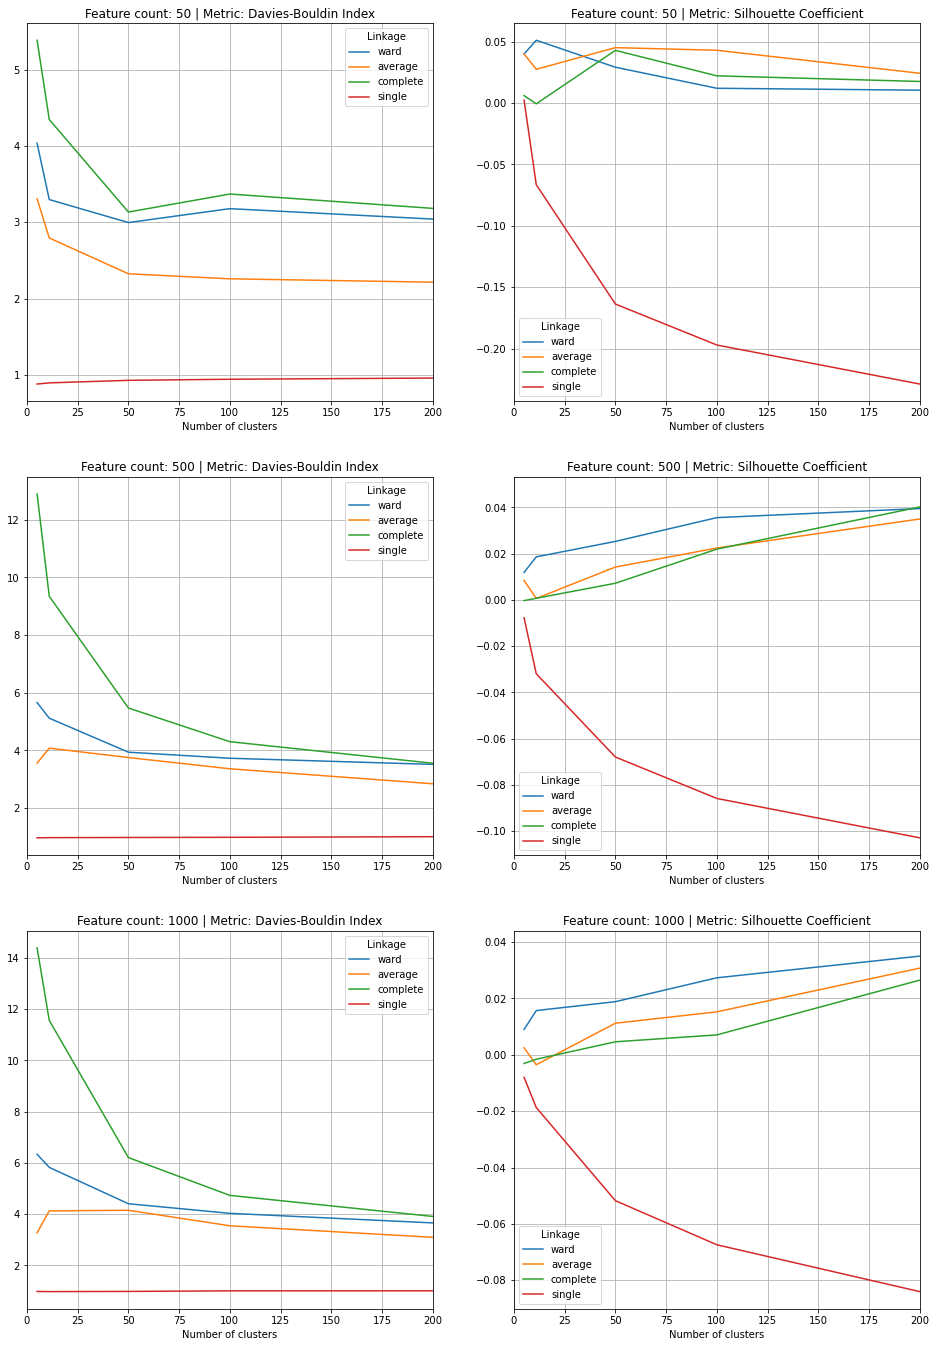

In [36]:
row = 3
col = 2

plt.figure(figsize=(col*8, row*8))

plt.subplot(row,col,1)
draw_agglo(results, 50, 'davies_score')

plt.subplot(row,col,2)
draw_agglo(results, 50, 'silhouette_score')

plt.subplot(row,col,3)
draw_agglo(results, 500, 'davies_score')

plt.subplot(row,col,4)
draw_agglo(results, 500, 'silhouette_score')

plt.subplot(row,col,5)
draw_agglo(results, 1000, 'davies_score')

plt.subplot(row,col,6)
draw_agglo(results, 1000, 'silhouette_score')

plt.savefig('./data/results/feature_agglomeration_linkage.jpg', dpi=250)

However the `single` linkage performes better with Davies-Bouldin Index, on average of both metrics, `average` linkage has the best score. 

### Compare algorithms

In [37]:
def draw(results_data, feature_counts, metric, ymin, ymax):
    for feature_count in feature_counts:
        sub_data = results_data[results_data['feature_count'] == feature_count]
        plt.plot(sub_data['n_cluster'], sub_data[metric])
        
    plt.legend(feature_counts.astype(int), title="Feature count" )
    plt.title('Algorithm: {} | Metric: {}'.format(
        algorithm_names[results_data['algorithm'].iloc[0]],
        metric_names[metric]
        ))
    plt.grid()
    plt.xlabel('Number of clusters')
    plt.xlim(0, 300)
    plt.ylim(ymin, ymax)

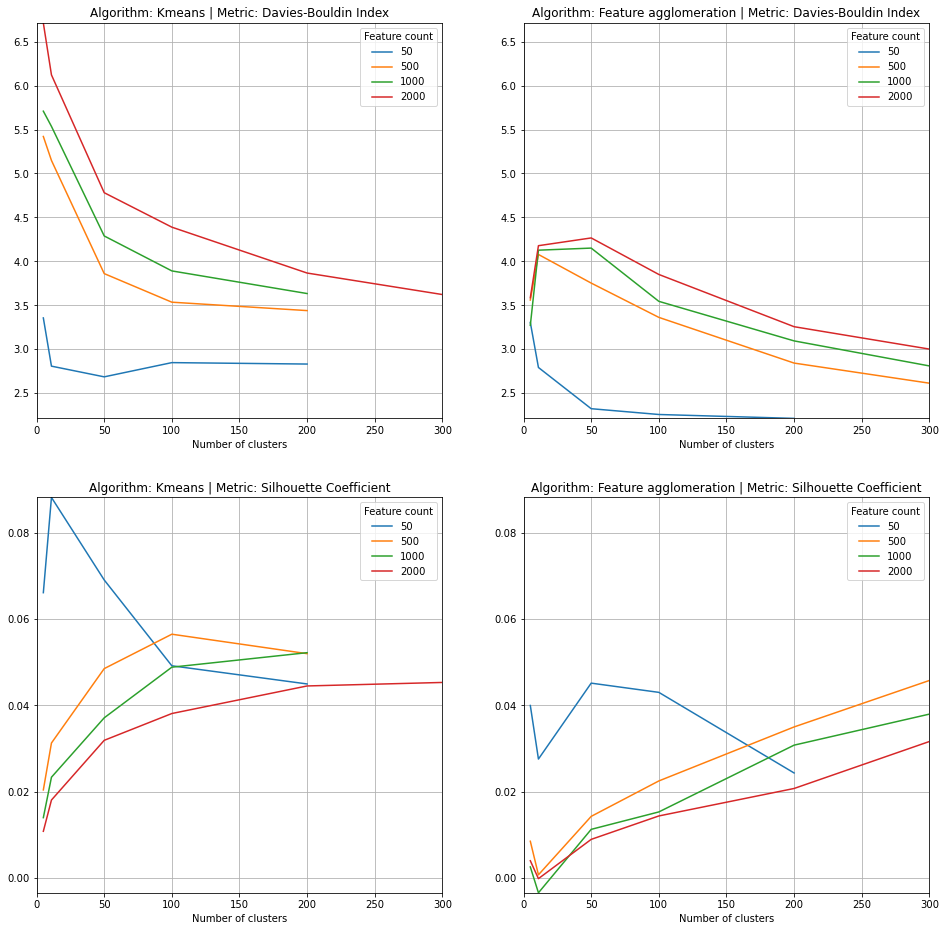

In [38]:
plt.figure(figsize=(16, 16))
feature_counts=  results['feature_count'].unique()

data_kmeans = results[results['algorithm'] == 'kmeans']
data_agglo = results[(results['algorithm'] == 'feature agglomeration') &
                     (results['linkage'] == 'average')]

davies_min = min(data_kmeans['davies_score'].min(), data_agglo['davies_score'].min())
davies_max = max(data_kmeans['davies_score'].max(), data_agglo['davies_score'].max())
silhouette_min = min(data_kmeans['silhouette_score'].min(), data_agglo['silhouette_score'].min())
silhouette_max = max(data_kmeans['silhouette_score'].max(), data_agglo['silhouette_score'].max())

plt.subplot(2,2,1)
draw(data_kmeans, feature_counts, 'davies_score', davies_min, davies_max)

plt.subplot(2,2,2)
draw(data_agglo, feature_counts, 'davies_score', davies_min, davies_max)

plt.subplot(2,2,3)
draw(data_kmeans, feature_counts, 'silhouette_score', silhouette_min, silhouette_max)

plt.subplot(2,2,4)
draw(data_agglo, feature_counts, 'silhouette_score', silhouette_min, silhouette_max)

plt.savefig('./data/results/algorithms.jpg', dpi=250)

### Conclusion

Based on the resualts, feature agglomeration algorithm performs better with the Davied-Bouldin Index metric and K-means algorithm have a better performance according to Silhouette Coefficient metric. Hence, final decision will depend on the metric which is closer to the requirements of the project. In the case of news clustering since news topics can overlap, and according to the fact that Silhouette Coefficient metric consider overlapping of data points of clusters as a negative factor, Davied Bouldin Index metric would be a better choise for our case. Therefore, feature agglomeration is our selected algorithm.